# Example - using ELiXer catalog library to return imaging cutouts and/or catalog objects


# if you are referencing the HDR1 directory or copied elixer locally, execute this cell (with the correct path to elixer)

In [ ]:
# if you are referencing the HDR1 directory or copied elixer locally, execute this cell (with the correct path to elixer)
import sys
sys.path.append('/work/03946/hetdex/hdr1/software/elixer')
import catalogs

# if you installed elixer with pip, execute this cell instead. If you are using Python3.x you will likely receive a series of deprecation warnings. For now, this is okay.

In [1]:
# if you installed elixer with pip, execute this cell
from elixer import catalogs
from elixer import classify

In [2]:

from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt

%matplotlib inline

## get instance of catalog library

In [3]:
catlib = catalogs.CatalogLibrary()

# build a position with astropy.coordinates.SkyCoord

In [4]:
coord = SkyCoord(150.025406,2.087600,unit='deg')

# Request package help information

In [5]:
help(catalogs)
#alternately you can request help on an instance of the CatalogLibrary object
#help(catlib)

#you can also request help on individual functions
#help(catlib.get_catalog_objects)

Help on module elixer.catalogs in elixer:

NAME
    elixer.catalogs - #import global_config as G

CLASSES
    builtins.object
        CatalogLibrary
    
    class CatalogLibrary(builtins.object)
     |  Methods defined here:
     |  
     |  __init__(self)
     |      Initialize self.  See help(type(self)) for accurate signature.
     |  
     |  build_catalog_list(self)
     |  
     |  find_catalogs(self, position)
     |      Build a list of catalogs whose footprint contains the position
     |      
     |      :param position: astropy SkyCoord
     |      :param radius: in deccimal degrees at the moment
     |      :return: list of catalog objects
     |  
     |  get_catalog_objects(self, position, radius, catalogs=None)
     |       Return a list of dictionaries of pandas dataframes of objects in imaging catalogs
     |      
     |      :param position: astropy SkyCoord
     |      :param radius: distance in arcsecs from the provided position in which to search for catalog obj

# simplest API ... get the list of known catalogs that contain the coord


In [6]:
cats = catlib.find_catalogs(position=coord)

print("Coord appears in (%d) catalogs." %len(cats))
for c in cats:
    print(c.name)
    

Coord appears in (1) catalogs.
STACK_COSMOS


# get the cutout images and data from call overlapping catalogs

# if you are running on your local machine with sshfs mount to TACC, this can take a little while to execute depending on the catalog (which depends on the sky position) and the size of the search radius

In [7]:
cutouts = catlib.get_cutouts(position=coord,radius=5.,aperture=1.5,dynamic=False) 
#radius is in arcsec is 1/2 the width of a side of the square (that is, you are searching position +/- radius)
#aperture is optional and is the radius (in arcsec) inside which to calculate a magnitude. Default is None (no calculation)
#Note: even if an aperture is supplied, if there is no conversion for a particular instrument/filter the mag will be None
#dynamic is optional (defaults to False) and sets whether the aperture can grow until the magnitude stabalizes
#you can also pass in a catalog list (such as cats from the cell above) to restrict the search to only those catalogs in the list
#cutouts = catlib.get_cutouts(position=coord,radius=60.,catalogs=cats)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


# What is returned is a list of dictionaries ... one for each matching catalog FITS image that contains the requested coordinate. The dictionary contains:

'cutout' = an astropy Cutout2D object (or None if there was an error)  

'path' = the full path to the FITS image from which the cutout was made

'hdu' = the HDU list from the FITS image  

'instrument' = the instrument name (like DECAM, or HSC, or HST-WFC-3)  

'filter' = the filter name  

'instrument' = the instrument name

'mag' = the calculated magnitude within the aperture radius if a conversion is available and aperture was specified

'aperture' = the aperture radius for the magnitude

The most common error would result in a None value for the cutout would be a FITS image in which the coordinate requested is in the footprint, but happens to be in an empty (no data) region

In [8]:
#exmaple of iterating through the cutouts 
for c in cutouts:
    print(c['path'])
    print(c['instrument'],c['filter'],c['mag'],c['aperture'])


/work/03946/hetdex/hdr1/imaging/cosmos/COSMOS/cosmos.g.image.fits
Subaru HSC g None None
/work/03946/hetdex/hdr1/imaging/cosmos/stackCOSMOS/nano/COSMOS_u_sci.fits
 u None None
/work/03946/hetdex/hdr1/imaging/cosmos/stackCOSMOS/nano/COSMOS_g_sci.fits
 g 24.880631028347885 1.5
/work/03946/hetdex/hdr1/imaging/cosmos/stackCOSMOS/nano/COSMOS_r_sci.fits
 r 24.619644097574316 1.5
/work/03946/hetdex/hdr1/imaging/cosmos/stackCOSMOS/nano/COSMOS_i_sci.fits
 i None None
/work/03946/hetdex/hdr1/imaging/cosmos/stackCOSMOS/nano/COSMOS_z_sci.fits
 z None None


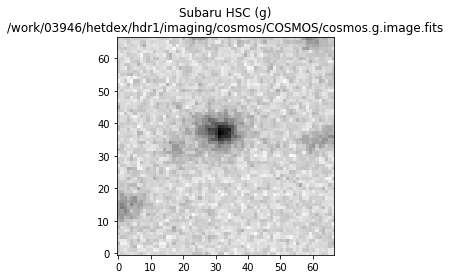

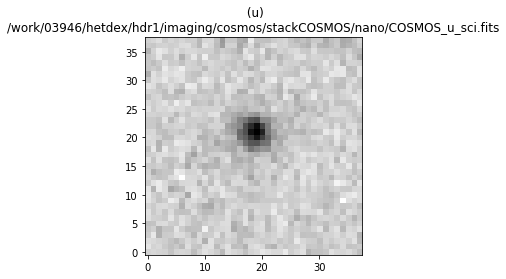

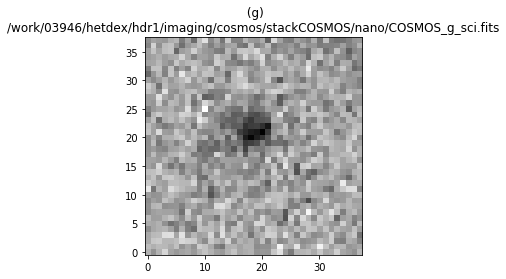

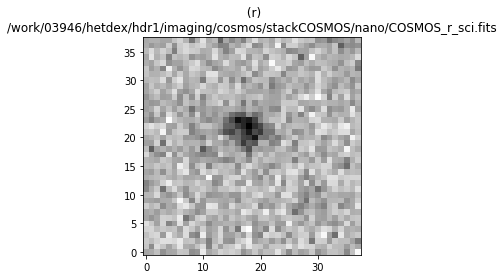

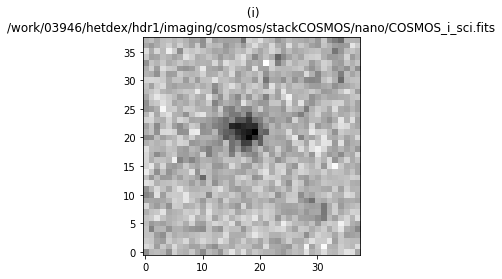

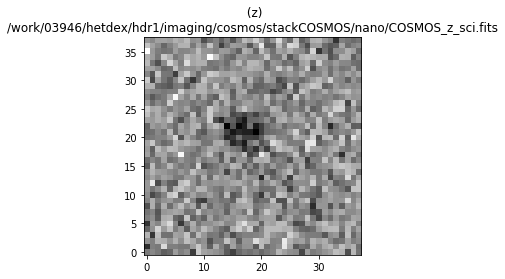

In [9]:
#exmaple of iterating through the cutouts with simple plots
for c in cutouts:
    plt.figure()
    plt.title("%s (%s)\n%s" %(c['instrument'],c['filter'],c['path']))
    plt.imshow(c['cutout'].data, origin="lower", cmap="gray_r")
    

# example of iterating through and writing out each as its own FITS 
# you can then open in ds9 and examine

In [10]:

import astropy.io.fits as fits

for i in range(len(cutouts)):
    co = cutouts[i]['cutout']
    hdu = fits.PrimaryHDU(co.data) #essentially empty header
    hdu.header.update(co.wcs.to_header()) #insert the cutout's WCS
    hdu.writeto('test_cutout_%d.fits' %i, overwrite=True)

# collect the catalog objects within the provided coordinate and radius


In [11]:
objs = catlib.get_catalog_objects(coord,10.)
#as with get_cutouts, you can also, optionally, pass in a list of catalogs to restrict the search
#objs = catlib.get_catalog_objects(coord,10./3600.,cats)

Reading main catalog for  STACK_COSMOS


What is returned is a list of dictionaries that include pandas dataframes from the overlapping catalogs. The dictionary contains:

'name' = the name of the catalog

'count' = the number of objects found within the radius

'dataframe' = the pandas data frame (the columns in the dataframe depend on the catalog, but will always contain 'RA','DEC', and 'distance' where distance is the angular distance from the target coordinate)


In [12]:
#find the number of objects
print(objs[0]['name'],objs[0]['count'])

#what columns are available
print(objs[0]['dataframe'].columns)

#here we iterate over the entries and print out some of the columns
for i,rec in objs[0]['dataframe'].iterrows():
    print(rec['RA'],rec['DEC'],rec['MAG_AUTO'],rec['distance'])

STACK_COSMOS 4
Index(['ID', 'RA', 'DEC', 'FLUX_AUTO', 'FLUXERR_AUTO', 'MAG_AUTO',
       'MAGERR_AUTO', 'distance', 'dist_prior'],
      dtype='object')
150.02540962192847 2.0877697097369734 -0.5871770977973938 0.00016974833071894821
150.02685673187574 2.089671906787409 -2.590500593185425 0.002528760163608183
150.02774557924081 2.0880270878613354 -0.20392510294914246 0.0023767144943791186
150.02305491270553 2.0881783979241066 -0.22997774183750153 0.002419673679966474
